# **Homework 2-1 Phoneme Classification**

## Result

scores:

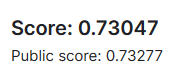


strong baseline:
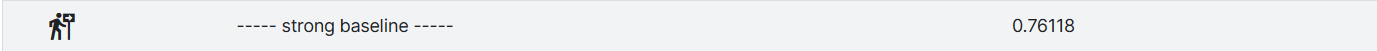

## Download Data

In [1]:
!gdown --id '1HPkcmQmFGu-3OknddKIa5dNDsR05lIQR' --output data.zip
!unzip data.zip
!ls

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1HPkcmQmFGu-3OknddKIa5dNDsR05lIQR
To: /content/data.zip
100% 372M/372M [00:01<00:00, 198MB/s]
Archive:  data.zip
   creating: timit_11/
  inflating: timit_11/train_11.npy   
  inflating: timit_11/test_11.npy    
  inflating: timit_11/train_label_11.npy  
data.zip  sample_data  timit_11


## Preparing Data

In [2]:
import numpy as np

print('Loading data ...')

data_root='./timit_11/'
train = np.load(data_root + 'train_11.npy')
train_label = np.load(data_root + 'train_label_11.npy')
test = np.load(data_root + 'test_11.npy')

print('Size of training data: {}'.format(train.shape))
print('Size of testing data: {}'.format(test.shape))

Loading data ...
Size of training data: (1229932, 429)
Size of testing data: (451552, 429)


## Create Dataset

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

class TIMITDataset(Dataset):
  def __init__(self, X, y=None):
    self.data = torch.from_numpy(X).float()

    if y is not None:
      y = y.astype(float)
      self.label = torch.LongTensor(y)

    else:
      self.label = None

  def __getitem__(self, idx):
    if self.label is not None:
      return self.data[idx], self.label[idx]

    else:
      return self.data[idx]

  def __len__(self):
    return len(self.data)

In [4]:
VAL_RATIO = 0.2

percent = int(train.shape[0] * (1 - VAL_RATIO))
train_x, train_y, val_x, val_y = train[:percent], train_label[:percent], train[percent:], train_label[percent:]
print('Size of training set: {}'.format(train_x.shape))
print('Size of validation set: {}'.format(val_x.shape))

Size of training set: (983945, 429)
Size of validation set: (245987, 429)


In [5]:
BATCH_SIZE = 512

from torch.utils.data import DataLoader

train_set = TIMITDataset(train_x, train_y)
val_set = TIMITDataset(val_x, val_y)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
import gc

del train, train_label, train_x, train_y, val_x, val_y
gc.collect()

0

## Create Model

In [7]:
import torch
import torch.nn as nn

class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    self.net = nn.Sequential(
      nn.Linear(429, 512),
      nn.BatchNorm1d(512),
      nn.ReLU(),
      nn.Dropout(0.2),

      nn.Linear(512, 1024),
      nn.BatchNorm1d(1024),
      nn.ReLU(),
      nn.Dropout(0.2),

      nn.Linear(1024, 2048),
      nn.BatchNorm1d(2048),
      nn.ReLU(),

      nn.Linear(2048, 1024),
      nn.BatchNorm1d(1024),
      nn.ReLU(),
      nn.Dropout(0.2),

      nn.Linear(1024, 512),
      nn.BatchNorm1d(512),
      nn.ReLU(),
      nn.Dropout(0.2),

      nn.Linear(512, 256),
      nn.BatchNorm1d(256),
      nn.ReLU(),
      nn.Dropout(0.2),

      nn.Linear(256, 128),
      nn.BatchNorm1d(128),
      nn.ReLU(),

      nn.Linear(128, 39),
    )

    self.criterion = nn.CrossEntropyLoss()

  def forward(self, x):
    out = self.net(x)

    return out

  def cal_loss(self, pred, target):

    l2 = 0
    for i in self.parameters():
      l2 += torch.sum(torch.pow(i, 2))

    loss = self.criterion(pred, target)

    return loss + 0.01 * l2, loss

## Training

In [8]:
def get_device():
  return "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [10]:
same_seeds(0)

device = get_device()
print(f'DEVICE: {device}')

num_epoch = 100
learning_rate = 1e-3

model_path = './model.ckpt'

model = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

DEVICE: cuda


In [21]:
best_acc = 0.0
for epoch in range(num_epoch):
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        l2_loss, batch_loss = model.cal_loss(outputs, labels)
        _, train_pred = torch.max(outputs, 1)
        l2_loss.backward()
        optimizer.step()

        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        train_loss += batch_loss.item()

    if len(val_set) > 0:
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, batch_loss = model.cal_loss(outputs, labels)
                _, val_pred = torch.max(outputs, 1)

                val_acc += (val_pred.cpu() == labels.cpu()).sum().item()
                val_loss += batch_loss.item()

            print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
                epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader), val_acc/len(val_set), val_loss/len(val_loader)
            ))

            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print('saving model with acc {:.3f}'.format(best_acc/len(val_set)))


    else:
        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
            epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader)
        ))

if len(val_set) == 0:
    torch.save(model.state_dict(), model_path)
    print('saving model at last epoch')


[001/100] Train Acc: 0.668715 Loss: 1.243308 | Val Acc: 0.698708 loss: 1.125849
saving model with acc 0.699
[002/100] Train Acc: 0.679065 Loss: 1.211470 | Val Acc: 0.704224 loss: 1.110216
saving model with acc 0.704
[003/100] Train Acc: 0.683408 Loss: 1.196558 | Val Acc: 0.706732 loss: 1.093267
saving model with acc 0.707
[004/100] Train Acc: 0.685265 Loss: 1.185725 | Val Acc: 0.711119 loss: 1.072653
saving model with acc 0.711
[005/100] Train Acc: 0.686973 Loss: 1.177433 | Val Acc: 0.711464 loss: 1.077814
saving model with acc 0.711
[006/100] Train Acc: 0.688686 Loss: 1.171454 | Val Acc: 0.713444 loss: 1.068292
saving model with acc 0.713
[007/100] Train Acc: 0.689848 Loss: 1.166724 | Val Acc: 0.710660 loss: 1.072013
[008/100] Train Acc: 0.691208 Loss: 1.161984 | Val Acc: 0.712790 loss: 1.063485
[009/100] Train Acc: 0.692147 Loss: 1.158303 | Val Acc: 0.712282 loss: 1.067403
[010/100] Train Acc: 0.693951 Loss: 1.155002 | Val Acc: 0.715497 loss: 1.064845
saving model with acc 0.715
[011

## Testing

In [22]:
test_set = TIMITDataset(test, None)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

model = Classifier().to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [23]:
predict = []
model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, test_pred = torch.max(outputs, 1)

        for y in test_pred.cpu().numpy():
            predict.append(y)

In [24]:
with open('prediction.csv', 'w') as f:
    f.write('Id,Class\n')
    for i, y in enumerate(predict):
        f.write('{},{}\n'.format(i, y))